In [1]:
import os
from io import StringIO

import pandas as pd
import numpy as np

Parse various samples of pollutants to AQHI into a CSV

In [15]:
# Various Barrie AQHIs from
# https://www.airqualityontario.com/aqhi/today.php?stationid=47045&start_day=29&start_month=12&start_year=2024&showType=table&station_id=47045&submitter=Refresh+page
AQHIs = """
2023-05-18 	2 	2 	2 	2 	2 	2 	2 	2 	3 	3 	3 	2 	2 	2 	3 	3 	3 	3 	3 	3 	3 	3 	3 	3
2023-05-19 	3 	3 	3 	3 	3 	2 	2 	3 	3 	3 	3 	3 	3 	3 	4 	4 	4 	5 	5 	4 	4 	4 	3 	3
2023-05-20 	3 	3 	3 	3 	2 	2 	2 	2 	2 	3 	4 	4 	4 	3 	3 	3 	2 	2 	2 	2 	2 	2 	2 	2
2023-06-05 	3 	3 	3 	3 	2 	2 	2 	2 	2 	3 	3 	2 	2 	3 	3 	3 	4 	4 	4 	4 	4 	4 	4 	4
2023-06-06 	3 	3 	3 	3 	3 	3 	3 	3 	3 	3 	3 	4 	5 	6 	7 	6 	6 	5 	5 	6 	6 	6 	5 	4
2023-06-07 	4 	3 	3 	2 	2 	2 	2 	3 	3 	3 	4 	5 	6 	6 	6 	5 	5 	5 	5 	4 	3 	3 	3 	2
2023-06-27 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3 	4 	5 	5 	5 	0 	0 	5 	4
2023-06-28 	4 	5 	5 	5 	5 	6 	6 	5 	4 	4 	5 	6 	6 	6 	6 	6 	8 	9 	9 	8 	5 	3 	3 	2
2023-06-29 	2 	3 	2 	3 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3 	3 	4 	4 	5 	5 	5 	6 	6 	6 	7
2023-08-22 	1 	1 	1 	1 	1 	1 	1 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2023-08-23 	2 	2 	2 	2 	2 	1 	1 	1 	1 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2023-08-24 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2023-11-27 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2023-11-28 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2023-11-29 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3 	3 	3 	3 	3 	2 	2 	2 	3
2024-02-11 	1 	1 	1 	1 	1 	1 	1 	1 	1 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2024-02-12 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3 	9 	4 	4 	2 	3 	3 	3 	3
2024-02-13 	3 	3 	3 	3 	3 	3 	3 	3 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2024-05-16 	2 	2 	2 	2 	2 	1 	0 	0 	0 	0 	2 	2 	2 	2 	2 	2 	2 	3 	3 	3 	3 	3 	3 	3
2024-05-17 	2 	2 	2 	2 	1 	1 	1 	1 	1 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	0 	0
2024-05-18 	0 	0 	2 	2 	2 	2 	1 	1 	1 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3 	3 	3 	3 	2
2024-07-30 	0 	0 	4 	4 	3 	3 	3 	3 	3 	3 	3 	2 	2 	3 	3 	3 	3 	3 	2 	2 	2 	2 	2 	2
2024-07-31 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3 	3 	3 	3
2024-08-01 	3 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3 	3 	3 	3 	3 	3 	3 	3 	3 	3 	4
2024-08-05 	2 	2 	2 	2 	4 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
2024-08-06 	2 	2 	2 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	2 	3 	2 	2 	2 	2 	1 	4
2024-08-07 	2 	2 	2 	1 	1 	3 	2 	1 	1 	1 	1 	1 	1 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	3
2024-12-29 	5 	3 	3 	3 	2 	2 	2 	2 	2 	2 	2 	1 	1 	1 	2 	1 	1 	1 	1 	1 	1 	2 	1 	1
2024-12-30 	1 	1 	2 	2 	2 	2 	2 	2 	2 	2 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	1 	2
2024-12-31 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2 	2
"""

In [16]:
# Step 1: Read the multiline string into a list of lines
lines = AQHIs.strip().split('\n')

# Step 2: Create a list of records (date, hour, AQHI)
records = []
for line in lines:
    parts = line.strip().split()
    date = parts[0]
    aqhis = parts[1:]
    for hour, value in enumerate(aqhis):
        records.append((date, hour, int(value)))

# Step 3: Create DataFrame
df_aqhi = pd.DataFrame(records, columns=["date", "hour", "AQHI"])

# Step 4: Convert date and hour to a datetime index
df_aqhi["datetime"] = pd.to_datetime(df_aqhi["date"]) + pd.to_timedelta(df_aqhi["hour"], unit="h")

# Step 5: Set datetime as index and drop extra columns
df_aqhi = df_aqhi.set_index("datetime")[["AQHI"]]

# Step 6: Sort by datetime index
df_aqhi = df_aqhi.sort_index()

# Optional: view first few rows
# df_aqhi

Identify accuracy relative to the given AQHI model

In [31]:
# Load the Barrie AQHI data
df_barrie = pd.read_csv(
    '../../data/processed/ontario/hourly/barrie.csv',
    parse_dates=True,
    index_col=0
)

# Standardize column names if necessary
df_barrie.columns = df_barrie.columns.str.lower()

# Filter both to overlapping time range
common_index = df_aqhi.index.intersection(df_barrie.index)

# Subset both DataFrames to the common index
df_aqhi_common = df_aqhi.loc[common_index]
df_barrie_common = df_barrie.loc[common_index]

# Compare: create a merged DataFrame
# df_compare = pd.DataFrame({
#     'aqhi_expected': df_aqhi_common['AQHI'].astype(float),  # from the string
#     'aqhi_actual': df_barrie_common['aqhi'].astype(float)   # from the CSV
# })

df_compare = df_barrie_common.copy()
df_compare = df_compare.rename(columns={"aqhi": "aqhi_actual"})
df_compare["aqhi_expected"] = df_aqhi_common["AQHI"].astype(float)

# Compute absolute error
df_compare["abs_error"] = (df_compare["aqhi_expected"] - df_compare["aqhi_actual"]).abs()

# Metrics
exact_match_accuracy = (df_compare["abs_error"] == 0).mean()
within_one_accuracy = (df_compare["abs_error"] <= 1).mean()
mae = df_compare["abs_error"].mean()
rmse = np.sqrt((df_compare["abs_error"] ** 2).mean())

# Print metrics
print(f"Exact Match Accuracy: {exact_match_accuracy:.2%}")
print(f"Within ±1 Accuracy: {within_one_accuracy:.2%}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: display mismatches
# df_mismatches = df_compare[df_compare["abs_error"] > 1]


Exact Match Accuracy: 70.69%
Within ±1 Accuracy: 94.58%
Mean Absolute Error (MAE): 0.35
Root Mean Squared Error (RMSE): 0.76


In [35]:
df_compare.to_csv('../../data/processed/ontario/tests/comparison.csv')

Identify accuracy relative to the summer and winter AQHI models

Devise a linear regression model, and identify accuracy

/home/aniket/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.48
Root Mean Squared Error (RMSE): 0.77
R-squared: 0.64


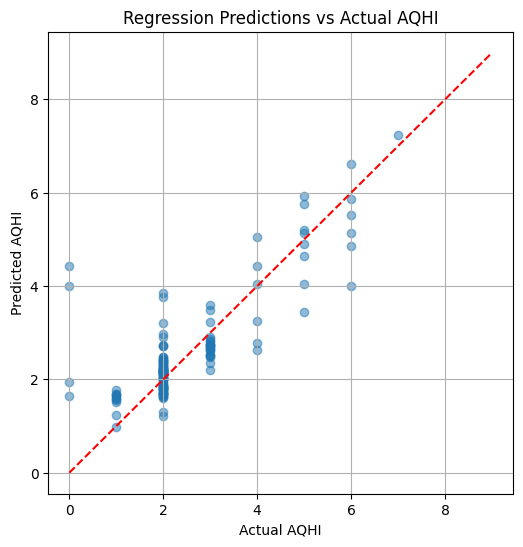

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load pollutant data
df_barrie = pd.read_csv(
    '../../data/processed/ontario/hourly/barrie.csv',
    parse_dates=True,
    index_col=0
)

# Step 2: Lowercase column names
df_barrie.columns = df_barrie.columns.str.lower()

# Step 3: Merge with df_aqhi using datetime index
df_barrie = df_barrie.drop(columns=["aqhi"], errors="ignore")

df_model = df_barrie.join(df_aqhi.rename(columns={"AQHI": "aqhi"}), how="inner")


# Step 4: Drop missing values
df_model = df_model.dropna(subset=["no2_3h_avg", "o3_3h_avg", "pm25_3h_avg", "aqhi"])

# Step 5: Define features and target
X = df_model[["no2_3h_avg", "o3_3h_avg", "pm25_3h_avg"]]
y = df_model["aqhi"]

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 8: Predict on test set
y_pred = model.predict(X_test)

# Step 9: Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Optional: Plot predictions vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual AQHI")
plt.ylabel("Predicted AQHI")
plt.title("Regression Predictions vs Actual AQHI")
plt.grid(True)
plt.show()
